<a href="https://colab.research.google.com/github/SethMinor/WSINDy-for-Python/blob/main/WSINDy_SH23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Swift-Hohenberg Equation
#####Based on the [JCP paper by **D. A. Messenger**, **D. M. Bortz** 2021](https://www.sciencedirect.com/science/article/pii/S0021999121004204). <br> See authors' original [MatLab code repository](https://github.com/MathBioCU/WSINDy_PDE).
#####Python code by Seth Minor, 2024.

---
**Swift-Hohenberg** (23) model: \begin{align*}
  u_t &= (r-1)u + \delta{u}^2 - u^3 - (2u_{xx} + 2u_{yy}) - (u_{xxxx} + 2u_{xxyy} + u_{yyyy}),
\end{align*} with parameters \begin{align*}
  \begin{cases}
  r = 0.4,
  \\
  \delta = 1 \ .
  \end{cases}
\end{align*}
Simulation data were obtained using MatLab's `chebfun` package, see `chebfun.org/examples/pde/SwiftHohenberg.html`.

In [1]:
# Access your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change directories
%cd /content/drive/My Drive/WSINDy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/WSINDy


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy
import itertools

# Symbolic derivatives
%pip install symengine
import symengine as sp

# Parallel and GPU
#import torch.nn.functional as nnF #GPU
#from concurrent.futures import ProcessPoolExecutor, as_completed # Parallel

# File path for empirical dataset
file_path = '/content/drive/My Drive/WSINDy'
data_path = file_path + '/Swift Hohenberg 23/SH23_1.txt'

# Read in CSV data
U = np.loadtxt(data_path, delimiter=',')

# Convert to torch tensor
U = torch.tensor(U)

# Reshape to Nx x Ny x Nt tensor
(Nx, Ny) = (200, 200)
U = U.view(Nx, Ny, -1)

print(f"Imported tensor with shape {U.shape}")

Imported tensor with shape torch.Size([200, 200, 101])


### Helper Functions

#### Specify Hyperparameters

In [29]:
# Two-piece linear approximation
def two_piece(x, x0, y0, m1, m2):
    return np.piecewise(x, [x<x0], [lambda x:m1*(x-x0)+y0, lambda x:m2*(x-x0)+y0])

# Define the scalar-valued function F(m)
def F(m,k,N,tau_hat,tau):
  log_term = np.log((2*m-1)/m**2)
  mid_term = (2*np.pi*k*m)**2 - 3*(tau_hat*N)**2
  last_term = 2*(tau_hat*N)**2 * np.log(tau)
  return log_term * mid_term - last_term

def optimal_support(U, d, two_piece, F, tau, tau_hat, **kwargs):
  # kwargs = {verbosity, init_guess}
  #-------------------------------------------
  # verbosity = create plots? (0 or 1)
  # init_guess = two-piece curve fitting guess
  #-------------------------------------------

  # Check kwargs
  if 'verbosity' in kwargs:
    verbosity = kwargs['verbosity']
  else:
    verbosity = 0
  if 'init_guess' in kwargs:
    init_guess = kwargs['init_guess']
  elif d < (U.dim()-1):
    init_guess = [15,1,10,0] # Space
  else:
    init_guess = [5,1,10,0] # Time

  # FFT of U in one variable (e.g., x)
  Uhat_d = abs(torch.fft.rfft(U, n = U.shape[d], dim = d))

  # Average over others (e.g., t and y)
  dimmers = [dim for dim in range(Uhat_d.ndimension()) if dim != d]
  Uhat_d = Uhat_d.mean(dim = dimmers)

  # Cumulative sum
  Hd = torch.cumsum(Uhat_d, dim = 0)
  Hd = (Hd/Hd.max()).numpy() # Normalize for curve fitting

  # Run curve-fittting routine
  freqs = torch.arange(0, np.floor(U.shape[d]/2)+1, 1).numpy()
  params = scipy.optimize.curve_fit(two_piece, freqs, Hd, p0=init_guess)[0]

  # Grab critical wavenumber
  k = int(params[0])
  N = U.shape[d]

  # Redefine init_guess for the root finder
  init_guess = (np.sqrt(3)*N*tau_hat)/(2*np.pi*k)
  init_guess = init_guess * (1 + np.sqrt(1 - (8/np.sqrt(3))*np.log(tau)))/2

  # Use the root function to find the root
  md = int(scipy.optimize.root(F, init_guess, args=(k,N,tau_hat,tau)).x[0])

  if verbosity == 1:
    # Print optimal support value
    print(f'Optimal test function support is m={md} (d={d+1}).')

    # Plot the critical wavenumber
    plt.style.use('_mpl-gallery')
    plt.rcParams['figure.figsize'] = [6, 2]
    fig, ax = plt.subplots()
    ax.plot(freqs, Uhat_d, 'r--', label='$\mathcal{F}[U]$')
    ax.plot(freqs, Uhat_d.max()*Hd, 'k', label='$H^d$ (rescaled)')
    ax.plot(freqs,Uhat_d.max()*two_piece(freqs,*params),'g--',label='Piecewise Approx')
    ax.plot(params[0], Uhat_d.max()*params[1],'go')
    ax.set_xlabel('$k$')
    ax.set_title(f'Critical Wavenumber, $k_d=${k} ($d=${d+1})')
    plt.legend(loc = 'best')
    plt.show()

  # Return optimal support
  return md

In [4]:
# Coordinate subsampling (x, y, or t)
def uniform_subsample(s, m, x):
  # Check size compatability
  if (2*m + 1) > x.shape[0]:
    raise Exception('Error: m produces non-compact support.')

  # Subsample
  xk = x[m:-m:s]

  # Compute indices of query points along given dimension
  indices = (x.unsqueeze(0) == xk.unsqueeze(1)).nonzero(as_tuple=True)[1]
  return indices.tolist()

# Apply 'mask' of subsampled query point indices to a given matrix
# (E.g., U[mask_rows, mask_cols] = Uk, as a vector)
def query_mask(s, m, X, D, **kwargs):
  # kwargs = {verbosity}
  #-------------------------------------------
  # verbosity = create plots? (0 or 1)
  #-------------------------------------------

  # Compute mask of query point indices
  subsamples = [uniform_subsample(s[i % len(s)], m[i % len(m)], X[i % len(X)]) for i in range(D+1)]
  my_mask = list(itertools.product(*subsamples))

  # Return mask
  mask = tuple(zip(*my_mask))

  # Optional plotting of query points
  # GENERALIZE THIS!!
  if ('verbosity' in kwargs) and (kwargs['verbosity'] == 1):
    if D == 2:
      X_mesh, Y_mesh, T_mesh = torch.meshgrid(X[0], X[1], X[-1], indexing='ij')
      Xk_mesh, Yk_mesh, Tk_mesh = torch.meshgrid(X[0][m[0]:-m[0]:s[0]],
                                                 X[1][m[1]:-m[1]:s[1]],
                                                 X[-1][m[-1]:-m[-1]:s[-1]],
                                                 indexing='ij')

      plt.style.use('_mpl-gallery')
      plt.rcParams['figure.figsize'] = [4, 4]
      fig, ax = plt.subplots()
      ax.pcolormesh(X_mesh[:,:,-1], Y_mesh[:,:,-1], U[:,:,-1])
      ax.scatter(Xk_mesh, Yk_mesh, color='red', s=3)
      ax.set_title('Query Points')
      ax.set_xlabel('$x$')
      ax.set_ylabel('$y$')
      print(f'\nQuery Points')
      plt.show()

  # Return
  return mask

#### Create Test Functions

In [5]:
# Calculate symbolic derivatives

def D_phibar(x, D, x_sym, phi_bar):
  # Dth derivative at degree p
  D_phi = sp.diff(phi_bar, x_sym, D)

  # Evaluate at point x
  if abs(x) < 1:
    return float(D_phi.subs(x_sym, x))
  else:
    return 0.0

In [6]:
def get_test_fcns(m, tau, x, alpha, d, D, **kwargs):
  # kwargs = {dx, p, scales, verbosity}
  #----------------------------------------
  # dx = space or time discretization
  # p = known degree for test fcns
  # scales = scale factors (yu, yx, yt)
  # verbosity = create plots? (0 or 1)
  #----------------------------------------

  # Number of points in x_d coordinate
  N = x.shape[0]

  # Check if dx (or dt) were provided
  if 'dx' in kwargs:
    dx = kwargs['dx']
  else:
    dx = (x[1] - x[0]).item()

  # Check if scaling factors were provided
  # ASSUMES IDENTICAL SPATIAL SCALING
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
    d_scale = (D*(yx,) + (yt,))[d]
    dx = d_scale * dx

  # Check size compatibility of support m
  if (m > (N-1)/2) or (m <= 1):
    raise Exception('Error: test fcn not compactly supported.')

  # Check if a known p was provided
  if 'p' in kwargs:
    p = kwargs['p']
  else:
    # Solve minimization problem for degree p
    alpha_bar = max(tuple(item[d] for item in alpha))
    log_tau_term = np.ceil(np.log(tau)/np.log((2*m-1)/m**2))
    p = max(log_tau_term, alpha_bar + 1)

  # Initialize grid of discretized test fcn values
  # INITIALIZE WITH EMPTY INSTEAD OF ZEROS (???)
  test_fcns_d = torch.zeros(len(alpha), 2*m+1, dtype = x.dtype)
  n_grid = torch.arange(-1, 1.0001, 1/m, dtype = x.dtype)

  # Multi-index values (a_d^i), for i=0,...,S
  multi_index_d = tuple(item[d] for item in alpha)

  # Precompute symbolic derivative variables
  x_sym = sp.Symbol('x')
  phi_bar = (1 - x_sym**2)**p
  vec = np.vectorize(D_phibar)

  # Compute D^i derivative of phi_d, for i=0,...,S
  for i in range(len(alpha)):
    # Speed-up: check for repeated values
    # SPEED-UP MORE BY CHECKING FOR WHOLE HISTORY OF VALUES (???)
    if (i > 0) and (multi_index_d[i-1] == multi_index_d[i]):
      test_fcns_d[i,:] += test_fcns_d[i-1,:]
    else:
      # Get multi-index value (a_d^i)
      num_derivs = multi_index_d[i]

      # Evaluate the (a_d^i) derivative on n_grid
      A_i = torch.from_numpy(vec(n_grid, num_derivs, x_sym, phi_bar))

      # Add the rescaled D^i derivative to the grid of values
      test_fcns_d[i,:] += (1/((m*dx)**num_derivs)) * A_i

  # Optional plotting of some test functions
  if ('verbosity' in kwargs) and (kwargs['verbosity'] == 1) and (d == 0):
    # Scaled test function grid
    y_grid = d_scale* torch.arange(-m*dx, m*dx+0.0001, dx)

    plt.style.use('_mpl-gallery')
    plt.rcParams['figure.figsize'] = [6, 2]
    fig, ax = plt.subplots()

    ax.plot(y_grid, test_fcns_d[1,:], label = '$\mathcal{D}^1$')
    ax.plot(y_grid, test_fcns_d[2,:], label = '$\mathcal{D}^2$')
    ax.plot(y_grid, test_fcns_d[3,:], label = '$\mathcal{D}^3$')
    ax.plot(y_grid, test_fcns_d[4,:], label = '$\mathcal{D}^4$')

    ax.set_title(f'A Few Test Functions $(d={d})$')
    ax.set_xlabel('$y = x_k - x$')
    ax.set_ylabel('${\phi_d}^{(a_d^i)} (y)$')
    plt.legend(loc = 'best')
    print(f'\nTest Functions')
    plt.show()

  # Return test function derivatives
  return test_fcns_d

In [7]:
# Speedy Test Function Creation
# Checks for and exploits redundancy in derivative library.

def speedy_test_fcns(m, p, tau, X, dX, alpha, D, **kwargs):
  # kwargs = {scales, verbosity}
  #------------------------------------
  # scales = scale factors (yu, yx, yt)
  # verbosity = create plots? (0 or 1)
  #------------------------------------

  # Initialize test functions
  test_fcns = []

  # The speed-up only makes sense for D>1 and equal spatial m,p values
  m_check = all([m[0] == m[n] for n in range(D)])
  p_check = all([p[0] == p[n] for n in range(D)])

  # Checking whether it makes sense to try the speed-up
  if (D == 1) or (m_check * p_check == False):
    go_condition = False
  else:
    try:
      # Building a condition to indicate if alpha is listed sequentially
      (a0, a1) = ([elem[0] for elem in alpha], [elem[1] for elem in alpha])
      a_max = max(a0)
      go_condition = (a0[2:2+a_max] == a1[2+a_max:2+2*a_max])
    except:
      # In case this throws an error due to a weird alpha structure
      print(f'Derivative library not given in a symmetric, sequential order.')
      go_condition = False

  # If the conditions aren't right, return the usual slow computation
  if (go_condition == False):
    print(f'\nUsing slow test function method...\n')
    for d in range(D + 1):
      (kwargs['dx'], kwargs['p']) = (dX[d], p[d])
      test_fcns.append(get_test_fcns(m[d], tau, X[d], alpha, d, D, **kwargs))
    return test_fcns

  # Otherwise, perform fast computation exploiting redundant derivatives
  else:
    # Index after which mixed/'cross' derivatives would start (if present)
    c_i = 2 + D*a_max

    # Maximum cross derivative
    if c_i < len(alpha):
      c_max = max([elem[0] for elem in alpha[c_i:]])

    # Define a permutation that allows computation of step (d+1) from step (d)
    # This takes indices [0,1,...,S-1] --> [block_1, block_2, block_3]
    normal_inds = [ind for ind in range(len(alpha))]

    # Block 1: the first two indices are fixed (D0 and D1)
    block_1 = normal_inds[0:2]

    # Block 2: pure derivative terms are shifted cyclically
    block_2 = normal_inds[2:c_i]
    block_2 = block_2[-a_max:] + block_2[0:-a_max]

    # Block 3: cross derivative terms are 'cut' and 'stretched'
    # (Note: this permutation is dependent of the value of 'd'.)
    block_3 = normal_inds[c_i:]
    if block_3 == []:
      # No cross derivatives are present
      block_3 = [[] for d in range(D-1)]
    else:
      # Cut and stretch the first '(d+1)*cross_max' variables over 'block_3'
      b3 = c_max**(D-2)
      block_3 = [(b3//(d+1))*[c_max*[ind] for ind in block_3[0:(d+1)*c_max]] for d in range(D-1)]
      block_3 = [[ind for elem in block_3[d] for ind in elem] for d in range(D-1)]

    # Compute the first and last test function
    tf_1 = get_test_fcns(m[0], tau, X[0], alpha, 0, D, **kwargs)
    test_fcns.append(tf_1)
    tf_d = tf_1 # The d^th test function
    tf_t = get_test_fcns(m[-1], tau, X[-1], alpha, D, D, **kwargs)

    # Use permuted indices to automatically compute the other test functions
    for d in range(1, D):
      perm_inds = block_1 + block_2 + block_3[d-1]
      tf_d = tf_d[perm_inds,:]

      # Rescale if needed
      if dX[0] != dX[d]:
        if d == 1:
          ad = a0
        elif d == 2:
          ad = a1
        else:
          ad = [elem[d-1] for elem in alpha]
        ad = torch.tensor(ad, dtype=tf_d.dtype).view(-1, 1)
        tf_d *= (dX[d-1]/dX[d])**ad

      # Add to list of test functions
      test_fcns.append(tf_d)

    # Add the temporal test function and return the list
    test_fcns.append(tf_t)
    return test_fcns

#### Rescaling the Data

In [8]:
# Carefully compute n-choose-k with non-integer k
def my_nchoosek(n,k):
  n_factorial = scipy.special.factorial(n)
  k_factorial = scipy.special.factorial(np.ceil(k))
  nk_term = scipy.special.factorial(n-np.floor(k))
  return n_factorial / (nk_term * k_factorial)

# Expects U as a list, [U1,...,Un]
# THIS IS CURRENTLY SET UP FOR IDENTICAL X AND Y

def get_scales(fj, alpha, U, m, dX, p, **kwargs):
  # kwargs = {scales}
  #-----------------------------------
  # scales = known scales (yu, yx, yt)
  #-----------------------------------

  # Check if known scales were provided
  if ('scales' in kwargs):
    # For multiple fields, yu should be a list
    (yu, yx, yt) = kwargs['scales']

  # Otherwise, compute scales
  else:
    # Maximum monomial power in library
    beta_bar = 0
    for n in range(len(U)):
      max_n = max(tuple(item[n] for item in fj['poly']))
      beta_bar = max(beta_bar, max_n)

    # Find maximum spatial derivative
    alpha_bar_x = 0
    for d in range(len(alpha[0]) - 1):
      max_d = max(tuple(item[d] for item in alpha))
      alpha_bar_x = max(alpha_bar_x, max_d)

    # Find maximum temporal derivative
    alpha_bar_t = max(tuple(item[-1] for item in alpha))

    # Compute L^2 norm of U and U^beta as vectors
    U_2 = [torch.linalg.norm(torch.reshape(u, (-1,))).item() for u in U]
    U_beta = [torch.linalg.norm(torch.reshape(u**beta_bar, (-1,))).item() for u in U]
    yu = [(U_2[n]/U_beta[n])**(1/beta_bar) for n in range(len(U))]

    # Compute scales using ansatz given in paper
    # ASSUMES IDENTICAL SPATIAL RESCALING
    yx = (1/(m[0]*dX[0])) * (my_nchoosek(p[0], alpha_bar_x/2)
          *scipy.special.factorial(alpha_bar_x))**(1/alpha_bar_x)
    yt = (1/(m[-1]*dX[-1])) * (my_nchoosek(p[-1], alpha_bar_t/2)
          *scipy.special.factorial(alpha_bar_t))**(1/alpha_bar_t)

  # Compute scale matrix, M = diag(mu)
  # Dimensions are K x SJ where J=beta_bar^n and n=no. of fields
  mu = torch.zeros((len(alpha)-1) * len(fj['poly']), dtype=U[0].dtype)

  for j in range(len(fj['poly'])):
    for i in range(1, len(alpha)):

      # Exclude derivatives of constants
      if (j == 0) and (i > 1):
        pass
      else:
        # Exponents for yx, yt
        x_exp = 0
        for d in range(len(alpha[0])-1):
          x_exp += alpha[i][d] - alpha[0][d]
        t_exp = alpha[i][-1] - alpha[0][-1]

        # GENERALIZE FOR TRIG FCNS, ETC.
        # Take product of u-scales
        yu_term = [yu[n]**(1-fj['poly'][j][n]) for n in range(len(U))]
        yu_term = np.prod(yu_term)

        # Set corresponding mu value
        mu[(i-1)*len(fj['poly']) + j] = yu_term * yx**x_exp * yt**t_exp

  # Make diagonal matrix
  M = torch.diag(mu)

  # Remove skipped columns
  # AUTOMATE THIS TO WORK WITH ANY FJ, ALPHA
  cols_to_remove = [len(fj['poly'])*c for c in range(1,len(alpha)-1)]
  Lib_mask = torch.ones(M.shape[1], dtype=torch.bool)
  Lib_mask[cols_to_remove] = False
  M = torch.diag(M[Lib_mask, Lib_mask])

  # Return scales and scale matrix
  return yu, yx, yt, M

#### Create the LHS

In [9]:
# Compute the LHS vector b
def create_b(U, test_fcns, dX, mask, D, **kwargs):
  # kwargs = {scales}
  #----------------------------------------
  # scales = scale factors ([yu's], yx, yt)
  #----------------------------------------

  # Check if scaling factors were provided
  # ASSUMES IDENTICAL SPATIAL SCALING
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
    (U_, dX_) = (yu*U, [yx*dx for dx in dX[0:-1]]+[yt*dX[-1]])
  else:
    (U_, dX_) = (U, dX)

  # Temporarily convert test functions to numpy arrays
  test_fcns_ = [test_fcn.numpy() for test_fcn in test_fcns]
  U_ = U_.numpy()

  # Convolve test function derivatives with data
  conv = U_
  for d in range(D+1):
    # Reshape test function appropriately
    slicing = [None] * len(test_fcns)
    slicing[d] = slice(None)

    # 1D convolution along the d-th axis
    conv = scipy.signal.convolve(conv, test_fcns_[d][tuple(slicing)], mode='same')

  # Convert back to pytorch tensor
  b = np.prod(dX_)*(torch.from_numpy(conv))

  # Convert to column vector and return
  b = (b[mask]).reshape(-1,1)
  return b

#### Create the Model Library

In [10]:
# Evaluate library functions {fj} on data
# (Note: j is 1-indexed here, so input j=1,...,J)

# Expects U as a list, U=[U1,...,Un]
# If aux fields exist, expects U=[...,V1,...,Vm]

def evaluate_fj(name, fj, j, U):
  # Monomial function for any number of fields (U1,...,Un)
  if name == 'poly':
    # Evaluate jth monomial, e.g., (u1)^3*(u2)^2
    fj_of_U_ = [(U[n]**fj[name][j-1][n]).numpy() for n in range(len(U))]
    fj_of_U_ = torch.from_numpy(np.prod(fj_of_U_, axis=0))

  # Sinus/cosinus for a single field u(x,t)
  # NOT YET IMPLEMENTED FOR MULTIPLE FIELDS
  elif name == 'trig':
    raise Exception('Trig functions not currently supported!')
    # Evaluate jth frequency [0], phase [1]
    #fj_of_U_ = np.sin(fj[name][j-1][0]*U + fj[name][j-1][1])

  # In case the given function is not defined
  else:
    raise Exception(f'Function "{name}" was not found.')

  # Return fj evaluated on data
  return fj_of_U_

In [11]:
# Compute column of model library
# (Evaluated for specific i,j)

# Expects U as a list, U=[U1,...,Un]
# If aux fields exist, expects U=[...,V1,...,Vm]

def get_library_column(fj_of_U, test_fcns, dX, mask, D, **kwargs):
  # kwargs = {scales}
  #----------------------------------------
  # scales = scale factors ([yu's], yx, yt)
  #----------------------------------------

  # Check if scaling factors were provided
  # ASSUMES IDENTICAL SPATIAL SCALING
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
    dX_ = [yx*dx for dx in dX[0:-1]] + [yt*dX[-1]]
  else:
    dX_ = dX

  # Temporarily convert test functions to numpy arrays
  test_fcns_ = [test_fcn.numpy() for test_fcn in test_fcns]
  fj_of_U_ = fj_of_U.numpy()

  # Convolve test function derivatives with data
  conv = fj_of_U_
  for d in range(D+1):
    # Reshape test function appropriately
    slicer = [None] * len(test_fcns)
    slicer[d] = slice(None)

    # 1D convolution along the d-th axis
    conv = scipy.signal.convolve(conv, test_fcns_[d][tuple(slicer)], mode='same')

  # Convert back to pytorch tensor
  Lij_matrix = np.prod(dX_)*(torch.from_numpy(conv))

  # Convert to column vector over query points and return
  Lij = (Lij_matrix[mask]).reshape(-1,1)
  return Lij

In [12]:
# Create the entire model library L
# Expects U as a list, U=[U1,...,Un]

def create_L(U, test_fcns, dX, mask, D, alpha, fj, **kwargs):
  # kwargs = {scales, aux_fields}
  #-------------------------------------------------
  # scales = scale factors ([yu's], yx, yt)
  # aux_fields = extra library variables [V1,...,Vm]
  #-------------------------------------------------

  #Initialize library variables
  L_kwargs = {}
  U_ = U

  # Check if scaling factors were provided
  # ASSUMES IDENTICAL SPATIAL SCALING
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
    L_kwargs['scales'] = (yu, yx, yt)

    # Rescale each field
    for n in range(len(yu)):
      U_[n] *= yu[n]

  # Check for extra variables
  if 'aux_fields' in kwargs:
    aux_fields = kwargs['aux_fields']
  else:
    aux_fields = []
  U_ += aux_fields

  # Create function names
  fj_names = ['poly']*len(fj['poly']) + ['trig']*len(fj['trig'])

  # The library is a K x SJ matrix
  (K, S, J) = (len(mask[0]), len(alpha)-1, sum(len(fcn) for fcn in fj.values()))
  L = torch.zeros(K, S*J, dtype=U[0].dtype)

  # Loop over all functions {fj}
  for j in range(1, J+1):
    # Compute fj(U)
    name = fj_names[j-1]
    fj_of_U = evaluate_fj(name, fj, j, U_)

    # Loop over all derivatives D^i
    for i in range(1, S+1):
      # Exclude derivatives of constants
      # (These are the D^i[f_1] for i=2,...,S terms)
      if (name == 'poly') and (j == 1) and (i > 1):
        pass
      else:
        # Get the corresponding test functions
        test_fcns_i = [test_fcn[i,:] for test_fcn in test_fcns]

        # Compute corresponding library column
        fj_of_U_ = fj_of_U.clone()

        # Check if GPU is available
        # GENERALIZE GPU CONVS TO ARB DIMENSION
        if torch.cuda.is_available() and (D < 3):
          Lij = get_library_column_gpu(fj_of_U_, test_fcns_i, dX, mask, D, **L_kwargs)
        else:
          Lij = get_library_column(fj_of_U_, test_fcns_i, dX, mask, D, **L_kwargs)
        L[:, (i-1)*J + j-1] = Lij[:, 0]

  # Remove skipped columns
  cols_to_remove = [len(fj['poly'])*c for c in range(1, S)]
  Lib_mask = torch.ones(L.shape[1], dtype=torch.bool)
  Lib_mask[cols_to_remove] = False
  L = L[:, Lib_mask]

  # Return complete model library
  return L

Trying `get_library_column` on the GPU

In [13]:
# Expects U as a list, U=[U1,...,Un]
# If aux fields exist, expects U=[...,V1,...,Vm]

def get_library_column_gpu(fj_of_U, test_fcns, dX, mask, D, **kwargs):
  # kwargs = {scales}
  #----------------------------------------
  # scales = scale factors ([yu's], yx, yt)
  #----------------------------------------

  # Check if scaling factors were provided
  # ASSUMES IDENTICAL SPATIAL SCALING
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
    dX_ = [yx*dx for dx in dX[0:-1]] + [yt*dX[-1]]
  else:
    dX_ = dX

  # Move tensors to GPU if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  fj_of_U = fj_of_U.to(device)
  test_fcns = [test_fcn.to(device) for test_fcn in test_fcns]

  # Convert test functions to appropriate PyTorch format
  conv = fj_of_U.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

  for d in range(D+1):
    # Reshape test function appropriately for 3D convolution
    test_fcn = test_fcns[d]
    slicer = [1, 1] + [1] * fj_of_U.dim()
    slicer[d+2] = -1
    test_fcn = test_fcn.view(*slicer)

    # Select appropriate convolution function
    # ADD GENERAL CASE (!!!)
    if fj_of_U.dim() == 1:
      conv = nnF.conv1d(conv, test_fcn, padding='same')
    elif fj_of_U.dim() == 2:
      conv = nnF.conv2d(conv, test_fcn, padding='same')
    elif fj_of_U.dim() == 3:
      conv = nnF.conv3d(conv, test_fcn, padding='same')
    else:
      raise ValueError(f"Unsupported dimension: {fj_of_U.dim()}")

  # Remove batch and channel dimensions
  conv = conv.squeeze(0).squeeze(0)

  # Compute the scaling factor
  Lij_matrix = torch.prod(torch.tensor(dX_, device=device)) * conv
  Lij_matrix = Lij_matrix.cpu()

  # Convert to column vector over query points and return
  Lij = Lij_matrix[mask].reshape(-1, 1)

  return Lij

Trying to get this to run in parallel.

In [14]:
# Define your evaluate_fj and get_library_column functions

def parallel_worker(i, j, fj_of_U, name, test_fcns, dX, mask, D, L_kwargs):
  if (name == 'poly') and (j == 1) and (i > 1):
    return None, (i, j)
  else:
    test_fcns_i = [test_fcn[i,:] for test_fcn in test_fcns]
    Lij = get_library_column(fj_of_U, test_fcns_i, dX, mask, D, **L_kwargs)
    return Lij[:, 0], (i, j)

In [15]:
# Create the entire model library L

# Expects U as a list, U=[U1,...,Un]
# If aux fields exist, expects U=[...,V1,...,Vm]

def create_L_parallel(U, test_fcns, dX, mask, D, alpha, fj, **kwargs):
  # kwargs = {scales, aux_fields}
  #-------------------------------------------------
  # scales = scale factors ([yu's], yx, yt)
  # aux_fields = extra library variables [V1,...,Vm]
  #-------------------------------------------------

  #Initialize library variables
  L_kwargs = {}
  U_ = U

  # Check if scaling factors were provided
  # ASSUMES IDENTICAL SPATIAL SCALING
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
    L_kwargs['scales'] = (yu, yx, yt)

    # Rescale each field
    for n in range(len(yu)):
      U_[n] *= yu[n]

  # Check for extra variables
  if 'aux_fields' in kwargs:
    aux_fields = kwargs['aux_fields']
  else:
    aux_fields = []
  U_ += aux_fields

  # Create function names
  fj_names = ['poly']*len(fj['poly']) + ['trig']*len(fj['trig'])

  # The library is a K x SJ matrix
  (K, S, J) = (len(mask[0]), len(alpha)-1, sum(len(fcn) for fcn in fj.values()))
  L = torch.zeros(K, S*J, dtype=U[0].dtype)

  futures = []
  with ProcessPoolExecutor() as executor:
    for j in range(1, J+1):
      name = fj_names[j-1]
      fj_of_U = evaluate_fj(name, fj, j, U_)
      for i in range(1, S+1):
        futures.append(executor.submit(parallel_worker, i, j, fj_of_U.clone(), name, test_fcns, dX, mask, D, L_kwargs))

    for future in as_completed(futures):
      result, (i, j) = future.result()
      if result is not None:
        L[:, (i-1)*J + j-1] = result

  cols_to_remove = [len(fj['poly'])*c for c in range(1, S)]
  Lib_mask = torch.ones(L.shape[1], dtype=torch.bool)
  Lib_mask[cols_to_remove] = False
  L = L[:, Lib_mask]

  return L

#### MSTLS Optimization

In [16]:
# Computes loss for a given candidate threshold
def loss(w_lambda, w_LS, L):
  # Least squares term
  LS_num = torch.linalg.norm(torch.matmul(L, w_lambda-w_LS)).item()
  LS_denom = torch.linalg.norm(torch.matmul(L, w_LS)).item()
  LS_term = LS_num / LS_denom

  # Zero norm term
  zero_norm = sum(w_lambda != 0).item()/w_lambda.shape[0]

  # Return total loss(lambda_n)
  loss_n = LS_term + zero_norm
  return loss_n

In [17]:
# MSTLS inner loop
def MSTLS_iterate(L, b, lambda_n, **kwargs):
  # kwargs = {w_LS, M, max_its}
  #----------------------------------------
  # w_LS = precomputed LS solution
  # M = scale matrix
  # max_its = maximum number of iterations
  #----------------------------------------

  if 'max_its' in kwargs:
    max_its = kwargs['max_its']
  else:
    max_its = L.shape[1]
  if 'M' in kwargs:
      M = kwargs['M']

  # Check if precomputed LS solution exists
  if 'w_LS' in kwargs:
    w_LS_ = kwargs['w_LS']
  # Otherwise, compute it
  else:
    w_LS_ = torch.linalg.lstsq(L, b, driver='gelsd').solution

  # Undo scaling if necessary
  if 'M' in kwargs:
    w_for_loss = w_LS_
    w_LS_ = torch.matmul(torch.diag(1/torch.diag(M)), w_LS_)

  # Compute |b|/|Li| bounds for all columns
  norm_b = torch.linalg.norm(b)
  norm_Li = torch.linalg.norm(L,dim=0)
  bounds = norm_b / norm_Li

  # Rescale the bounds if necessary
  if 'M' in kwargs:
    mu = torch.diag(M)
    bounds = bounds / mu

  # Define upper and lower bounds (lambda thresholding)
  L_bounds = lambda_n*torch.maximum(bounds,torch.ones(bounds.shape[0]))
  U_bounds = 1/lambda_n*torch.minimum(bounds,torch.ones(bounds.shape[0]))

  # Begin applying iterative thresholding on elements of weight vector
  iteration = 0
  w_n = w_LS_
  inds_old = torch.tensor([0])
  while iteration <= max_its:
    # Find in-bound and out-of-bound indices and set them to zero
    ib_inds = torch.where((abs(w_n[:,0])>=L_bounds)&(abs(w_n[:,0])<=U_bounds))[0]
    oob_inds = torch.where((abs(w_n[:,0])<L_bounds)|(abs(w_n[:,0])>U_bounds))[0]

    # Check stopping condition
    if (torch.equal(inds_old, ib_inds)) or (ib_inds.shape[0]==0):
      break

    # Find LS solution amongst sparser, in-bound indices
    w_n[ib_inds] = torch.linalg.lstsq(L[:,ib_inds], b, driver='gelsd').solution
    # Mask oob columns of L
    w_n[oob_inds] = 0

    # Rescale sparse solution if needed
    if 'M' in kwargs:
      w_n = torch.matmul(torch.diag(1/torch.diag(M)), w_n)

    # Update loop variables
    inds_old = ib_inds
    iteration += 1
    if iteration == max_its:
      print('MSTLS reached the maximum number of iterations allowed.')

  # Evaluate the loss function on the resulting weights
  if 'M' in kwargs:
    # Loss evaluated on scaled weights
    loss_n = loss(torch.matmul(M,w_n), w_for_loss, L)
  else:
    # Loss evaluated on input weights (scaled or unscaled)
    loss_n = loss(w_n, w_LS_, L)
  return w_n, loss_n

In [18]:
# Full MSTLS optimization, minimizing loss
def MSTLS(L, b, lambdas, **kwargs):
  # kwargs = {threshold, w_LS, M, max_its}
  #----------------------------------------
  # threshold = known optimal threshold
  # w_LS = precomputed LS solution
  # M = scale matrix (according to paper)
  # max_its = maximum number of iterations
  #----------------------------------------

  if 'max_its' in kwargs:
    max_its = kwargs['max_its']
  else:
    max_its = L.shape[1]
  if 'M' in kwargs:
    M = kwargs['M']

  # If needed, cast L,b to common data type
  if b.dtype != L.dtype:
    b.to(torch.float64) #LHS
    L.to(torch.float64) #RHS

  # Check if precomputed LS solution exists
  if 'w_LS' in kwargs:
    w_LS_ = kwargs['w_LS']
  # Otherwise, compute w_LS
  else:
    w_LS_ = torch.linalg.lstsq(L,b, driver='gelsd').solution

  # Check if known optimal threshold was provided
  if 'threshold' in kwargs:
    lambda_star = kwargs['threshold']

  # Otherwise, iterate to find lambda_star
  else:
    # If multidimensional, iterate over each field
    lambda_stars = []

    for n in range(w_LS_.shape[1]):
      w_LS_n = w_LS_[:,n].reshape(-1,1) # Get a column for a particular field Un
      b_n = b[:,n].reshape(-1,1)
      loss_history = []

      for lambda_n in lambdas:
        # Compute candidate weights and evaluate loss
        if 'M' in kwargs:
          w_n,loss_n = MSTLS_iterate(L,b_n,lambda_n.item(),w_LS=w_LS_n,M=M,max_its=max_its)
        else:
          w_n,loss_n = MSTLS_iterate(L,b_n,lambda_n.item(),w_LS=w_LS_n,max_its=max_its)
        loss_history.append(loss_n)

      # Find optimal candidate threshold for each field Un
      # (Automatically finds smallest minimzer, if not unique)
      ind_star = loss_history.index(min(loss_history))
      lambda_star = lambdas[ind_star].item()
      lambda_stars.append(lambda_star)

  # Use the optimal threshold to compute the final sparse weights
  w_stars = []
  loss_stars = []

  # Again, iterate over each field
  for n in range(w_LS_.shape[1]):
    w_LS_n = w_LS_[:,n].reshape(-1,1)
    b_n = b[:,n].reshape(-1,1)
    lambda_star = lambda_stars[n]

    if 'M' in kwargs:
      w_star_,loss_star_ = MSTLS_iterate(L,b_n,lambda_star,w_LS=w_LS_n,M=M,max_its=max_its)
      w_stars.append(w_star_)
      loss_stars.append(loss_star_)
    else:
      w_star_,loss_star_ = MSTLS_iterate(L, b_n, lambda_star, w_LS=w_LS_n, max_its=max_its)
      w_stars.append(w_star_)
      loss_stars.append(loss_star_)

  # Return final result
  w_star_ = torch.cat(w_stars, 1)
  return w_star_, lambda_stars, loss_stars

#### Print the Results

In [19]:
# Prints a report of WSINDy run

def print_report(**kwargs):
  # kwargs = {verbosity, thresh, loss_val, L, scales, p, s}
  #----------------------------------------
  # verbosity = create plots? (0 or 1)
  # thresh = optimal MSTLS threshold
  # loss_val = minimum MSTLS loss value
  # L = model library
  # scales = scale factors ([yu's], yx, yt)
  # p = test function degrees
  # s = query point subsampling rates
  #----------------------------------------

  if 'verbosity' not in kwargs:
    return

  elif kwargs['verbosity'] == 1:

    # Check if GPU was utilized
    if torch.cuda.is_available():
      print(f'\nLibrary computed with CUDA ({torch.cuda.get_device_name()}).')

    if 'thresh' and 'loss_val' in kwargs:
      # Print optimal MSTLS parameters
      (thresh, loss_val) = (kwargs['thresh'], kwargs['loss_val'])
      print(f'\nOptimal threshold = {thresh}\nOptimal loss = {loss_val}')

    if 'L' and 'scales' and 'p' and 's' in kwargs:
      # Print the condition number of the library matrix
      (L,scales,p,s) = (kwargs['L'],kwargs['scales'],kwargs['p'],kwargs['s'])
      print(f'\nCond(L) = {torch.linalg.cond(L,p=2)}\n')
      print(f'scales = {scales}\np = {p}\ns = {s}\n')

    return

In [20]:
# Returns a string for each possible term in the model library.
# Expects U as a list, U=[U1,...,Un]
# NOT SET UP FOR TRIG FCNS YET

def get_term_names(U, fj, alpha, D, **kwargs):
  # kwargs = {aux_fields}
  #-------------------------------------------------
  # aux_fields = extra library variables [V1,...,Vm]
  #-------------------------------------------------

  # Check if extra variables were provided
  if 'aux_fields' in kwargs:
    aux_fields = kwargs['aux_fields']
  else:
    aux_fields = []
  U_ = U + aux_fields

  # Format derivative library as a list of strings
  alpha_names = []
  for elem in alpha:
    if all(value == 0 for value in elem):
      alpha_names.append('')
    else:
      # 1D, 2D, 3D case-handling
      if D == 1:
        alpha_names.append('_'+'t'*elem[1]+'x'*elem[0])
      elif D == 2:
        alpha_names.append('_'+'t'*elem[2]+'x'*elem[0]+'y'*elem[1])
      elif D == 3:
        alpha_names.append('_'+'t'*elem[3]+'x'*elem[0]+'y'*elem[1]+'z'*elem[2])
      # General case
      else:
        string = [('x' + str(n+1) + ',')*elem[n] for n in range(len(elem)-1)]
        string = ('_'+'t,'*elem[3] + ''.join(string)).rstrip(',')
        alpha_names.append(string)

  # Term names (e.g., 'u_t', 'u_x' etc.)
  # Case-handling for 1, 2, and 3 fields
  if len(U + aux_fields) <= 3:
    field_names = ['u', 'v', 'w'][0:len(U_)]
  # General case
  else:
    field_names = ['u' + str(n+1) for n in range(len(U_))]

  LHS_names = [str(u) + alpha_names[0] for u in field_names]
  RHS = [field_names[n] + '^' + str(fj['poly'][elem][n])
         for elem in range(len(fj['poly'])) for n in range(len(U_))]
  RHS = [''.join(RHS[i:i+len(U_)]) for i in range(0, len(RHS), len(U_))]
  RHS = ['(' + elem + ')' for elem in RHS]
  RHS = [u + Di for Di in alpha_names[1:] for u in RHS]

  # Remove skipped terms
  remove = [len(fj['poly'])*c for c in range(1,len(alpha)-1)]
  RHS_names = [term for col, term in enumerate(RHS) if col not in remove]

  term_names = (LHS_names, RHS_names)
  return term_names

In [21]:
# Get discovered PDE model symbolically, as a string

def get_model(w, term_names):
  # Split into LHS and RHS
  (LHS_names, RHS_names) = term_names

  # Find nonzero RHS terms
  inds = [torch.nonzero(w[:,n])[:,0].tolist() for n in range(w.shape[1])]

  # Append terms onto model
  model = []
  for n in range(w.shape[1]):
    terms_n = ['({0:.2f})'.format(w[ind,n].item())+RHS_names[ind] for ind in inds[n]]

    # Add to evolution operator
    model_n = LHS_names[n] + ' = ' + ' + '.join(terms_n)
    model.append(model_n)

  # Collapse to a single string and return
  model = '\n'.join(model)
  return model

#### Kwarg Handling for `wsindy` Function

Kwargs handling function

In [22]:
def kwarg_handling(U, alpha, **kwargs):

  # WSINDy Kwarg Handling Function
  # This function manages the following hyperparameters.
  #-----------------------------------------------------
  # x = spatial domain(s)
  # dx = spatial discretization(s)
  # t = temporal domain
  # dt = temporal discretization
  # aux_fields = extra variables for term library
  #
  # m = explicit (mx,...,mt) values
  # s = explicit (sx,...,st) values
  # lambdas = MSTLS threshold search space
  # threshold = known optimal threshold
  # p = explicit (px,...,pt) values
  # tau = test function tolerance
  # tau_hat = Fourier test function tolerance
  # scales = explicit (yu,yx,yt) scaling factors
  # M = scaling matrix
  #
  # verbosity = create plots? (0 or 1)
  # init_guess = initial guess for (kx,kt) curve fitting
  # max_its = specify maximum number of MSTLS iterations
  # sigma_NR = noise ratio of artifical gaussian noise
  #-----------------------------------------------------

  # Dimensionality
  #---------------------------------------------------------------------------
  # --- Multiple Fields ---
  # Check if state vector is multi-dimensional U=(U1,...,Un)
  if type(U) is list:
    multi_flag = 1 # Multiple fields detected
  else:
    multi_flag = 0 # Single field detected

  # Avoiding some if statements below
  # For convenience later on
  U_ = [[U], U][multi_flag] # List-ify
  dtype_ = U_[0].dtype
  Ushape_ = U_[0].shape

  # --- Auxiliary Fields ---
  # Extra variables to be included in library
  if 'aux_fields' in kwargs:
    aux_fields = kwargs['aux_fields']
  else:
    aux_fields = []

  # Check that function list {fj} is the correct shape
  if (fj['poly'][0] != ()) and (len(fj['poly'][0]) != len(U_+aux_fields)):
    raise Exception("Nonempty 'fj['poly']' does not match the shape of 'U'.")

  # Check that constant term exists (D^1 = zeros, f1 = zeros)
  # TEMPORARY ---> AUTOMATE THIS (???)
  if all(fj['poly'][0]) != all(alpha[1]):
    raise Exception('Column removal not compatible with given fj, alpha.')

  # --- Discretized Grid ---
  # Space
  if ('x' in kwargs) and ('dx' in kwargs):
    (x, dX) = (kwargs['x'], kwargs['dx'])
    (D, X) = (len(x), []) # No. and list of spatial variables
    for d in range(D):
      X.append(torch.arange(x[d][0], x[d][1]+dX[d], dX[d], dtype=dtype_))

  elif ('x' in kwargs) ^ ('dx' in kwargs):
    raise Exception("Both 'x' and 'dx' must be provided simultaneously.")

  else: # Set unit square domain by default
    dX = []
    X = []
    D = U_[0].dim()-1
    for d in range(D):
      dX.append(1/(Ushape_[d]))
      X.append(torch.arange(x[d][0], x[d][1]+dX[d], dX[d], dtype=dtype_))

  # Time
  if ('t' in kwargs) and ('dt' in kwargs):
    (t, dt) = (kwargs['t'], kwargs['dt'])
    dX.append(dt)
    X.append(torch.arange(t[0], t[1]+dt, dt, dtype=dtype_))

  elif ('t' in kwargs) ^ ('dt' in kwargs):
    raise Exception("Both 't' and 'dt' must be provided simultaneously.")

  else:
    dt = 1/(Ushape_[-1])
    dX.append(dt)
    X.append(torch.arange(0, 1+dt, dt, dtype=dtype_))
  #---------------------------------------------------------------------------

  # Kwarg Checking
  #---------------------------------------------------------------------------
  # --- Hyperparameters ---
  # Test function support (m)
  if 'm' in kwargs:
    m = kwargs['m']
    m_flag = 0
  else:
    m_flag = 1 # Automatically compute m

  # Query point subsampling rate (s)
  if 's' in kwargs:
    s = kwargs['s']
  else:
    s = (int(Ushape_[0]/25),)*D + (int(Ushape_[-1]/25),)

  # Threshold search space (lambdas)
  if 'lambdas' in kwargs:
    lambdas = kwargs['lambdas']
  else:
    # Default search space
    lambdas = 10**((4/49)*torch.arange(0,50)-4)

  # Known optimal threshold (threshold)
  if 'threshold' in kwargs:
    threshold = kwargs['threshold']
  else:
    threshold = None

  # Test function degrees (p)
  if 'p' in kwargs:
    p = kwargs['p']
    p_flag = 0
  else:
    p_flag = 1 # Automatically compute p

  # Test function tolerances (tau, tau_hat)
  if 'tau' in kwargs: # Real space
    tau = kwargs['tau']
  else:
    tau = 1E-10
  if 'tau_hat' in kwargs: # Fourier
    tau_hat = kwargs['tau_hat']
  else:
    tau_hat = 2

  # --- Miscellaneous ---
  # Display information and plots
  if 'verbosity' in kwargs:
    verbosity = kwargs['verbosity']
  else:
    verbosity = 0

  # Curve-fitting initial guess (x, y, slope1, slope2)
  if 'init_guess' in kwargs:
    init_guess = kwargs['init_guess']
    init_guess_x = init_guess[0]
    init_guess_t = init_guess[1]
  else:
    init_guess_x = [15, 1, 10, 0]
    init_guess_t = [3, 1, 10, 0.25]

  # Maximum inner MSTLS loop iterations
  if 'max_its' in kwargs:
    max_its = kwargs['verbosity']
  else:
    max_its = None # Use default value

  # Artifical noise
  if 'sigma_NR' in kwargs:
    # Add noise to data
    sigma_NR = kwargs['sigma_NR']

    if multi_flag == 0:
      U_rms = (torch.sqrt(torch.mean(U**2))).item();
      sigma = sigma_NR * U_rms
      epsilon = torch.normal(mean=0, std=sigma, size=Ushape_, dtype=dtype_)
      U = U + epsilon

    else:
      U_rms = [(torch.sqrt(torch.mean(u**2))).item() for u in U]
      U_noise = []
      for n in range(len(U)):
        sigma = sigma_NR * U_rms[n]
        epsilon = torch.normal(mean=0, std=sigma, size=Ushape_, dtype=dtype_)
        U_noise.append(U[n] + epsilon)
      U = U_noise

    # Re-listify
    U_ = [[U], U][multi_flag]
  #---------------------------------------------------------------------------

  # Automatic Hyperparameter Selection
  #---------------------------------------------------------------------------
  # Test function support
  if m_flag == 1:
    # The first field U=(U1,...,Un) will be used to determine m
    U1_ = [U, U[0]][multi_flag]
    m = []

    # Space (mx, my, ...)
    m_kwargs = {'verbosity':verbosity, 'init_guess':init_guess_x}
    for d in range(D):
      m.append(optimal_support(U1_, d, two_piece, F, tau, tau_hat, **m_kwargs))

    # Time (mt)
    m_kwargs = {'verbosity':verbosity, 'init_guess':init_guess_t}
    m.append(optimal_support(U1_, D, two_piece, F, tau, tau_hat, **m_kwargs))

  # Test function degrees
  if p_flag == 1:
    # Solve minimization problem for degree p
    p = []
    for d in range(D + 1):
      alpha_bar = max(tuple(item[d] for item in alpha))
      log_tau_term = np.ceil(np.log(tau)/np.log((2*m[d]-1)/m[d]**2))
      p.append(max(log_tau_term, alpha_bar + 1))

  # Scaling factors (yu, yx, yt) and scaling matrix (M)
  # ASSUMES IDENTICAL SPATIAL RESCALING
  if ('scales' in kwargs) and ('M' in kwargs):
    (scales, M) = (kwargs['scales'], kwargs['M'])
  else:
    # Automatically compute scales
    yu, yx, yt, M = get_scales(fj, alpha, U_, m, dX, p)
    scales = (yu, yx, yt)

  # Also for convenience later on (for LHS)
  LHS_kwargs = [(scales[0][n],)+scales[-2:] for n in range(len(U_))]

  # Test function kwargs
  tf_dict = {'scales':scales, 'verbosity':verbosity}

  # MSTLS kwargs
  MSTLS_dict = {'M' : M}
  if threshold is not None:
    MSTLS_dict['threshold'] = threshold
  if max_its is not None:
    MSTLS_dict['max_its'] = max_its

  # print_report kwargs
  print_dict = {'verbosity':verbosity, 'scales':scales, 'p':p, 's':s}
  model_dict = {'aux_fields':aux_fields}

  # Create query point mask
  # The same mask should be applied to all fields U=(U1,...,Un)
  mask = query_mask(s, m, X, D, verbosity=verbosity)
  #---------------------------------------------------------------------------

  # Return algorithm parameters
  grid = (U_, D, X, dX, aux_fields)
  dicts = (print_dict, tf_dict, LHS_kwargs, MSTLS_dict, model_dict)
  hyperparams = (m, lambdas, p, tau, scales, mask)

  return grid, dicts, hyperparams

#### Library Formatting

In [23]:
# Conveniently formats function library
# Increments f1 first, then f2, etc...

# NOTE: on/off fields should occur at the end of U=(U1,...) list.

def get_poly(powers, fields, **kwargs):
  # kwargs = {on_off}
  # --------------------------------------------------------------------------
  # on_off = m, include last m fields of (U1,...,Un) via an exponent := 0 or 1
  # on_off_cross = exlcude cross-terms (U1^a)*(U2^b) for on/off fields?
  # --------------------------------------------------------------------------

  # Search for on/off fields
  if 'on_off' in kwargs:
    on_off = kwargs['on_off']
  else:
    on_off = 0
  if 'on_off_cross' in kwargs:
    on_off_cross = kwargs['on_off_cross']
  else:
    on_off_cross = True

  # Compute unrestricted powers
  pows = list(range(powers+1))
  poly = [elem[::-1] for elem in itertools.product(pows, repeat=fields-on_off)]

  # Add on/off fields
  if on_off_cross == True:
    # Include potential cross terms
    for m in range(on_off):
      poly = [list(elem)+[[0],[1]][n] for n in range(2) for elem in poly]
  else:
    # Exclude potential cross terms
    poly = [list(elem)+(on_off*[0]) for elem in poly]
    for m in range(fields-on_off, fields):
      on_off_term = fields*[0]
      on_off_term[m] = 1
      poly.append(on_off_term)

  # Return as a tuple
  poly = tuple([tuple(elem) for elem in poly])
  return poly

In [24]:
# Conveniently formats the derivative library
# Increments x partials first, then y partials, etc...
# (Currently only supports 1D, 2D, and 3D)

def get_alpha(D, pure_derivs, cross_derivs):
  rhs = [(D+1)*(0,)]

  # GENERALIZE THIS (?)
  if D > 3:
    raise Exception("'alpha_rhs' currently only supports 1D, 2D, and 3D.")

  # Pure derivatives
  for i in range(1, pure_derivs+1):
    rhs.append(tuple([i]) + D*(0,)) # x partials

  if D > 1:
    for j in range(1, pure_derivs+1):
      rhs.append(tuple([0,j]) + (D-1)*(0,)) # y partials

  if D > 2:
    for k in range(1, pure_derivs+1):
      rhs.append(tuple([0,0,k]) + (D-2)*(0,)) # z partials

  # Cross derivatives
  if D == 2:
    for j in range(1, cross_derivs+1):
      for i in range(1, cross_derivs+1):
        rhs.append((i, j, 0))

  elif D == 3:
    for k in range(cross_derivs+1):
      for j in range(cross_derivs+1):
        for i in range(cross_derivs+1):
          if (i,j,k) == (0,0,0):
            pass
          elif (i,j)==(0,0) or (i,k)==(0,0) or (j,k)==(0,0):
            pass
          else:
            rhs.append((i, j, k, 0))

  return tuple(rhs)

### Weak SINDy

In [25]:
def wsindy(U, fj, alpha, **kwargs):

  # Kwarg Checking and Hyperparameters (see 'kwarg_handling')
  #---------------------------------------------------------------------------
  # Find WSINDy settings
  grid, dicts, hyperparams = kwarg_handling(U, alpha, **kwargs)

  # Individual variables/hyperparameters
  (U, D, X, dX, aux_fields) = grid
  (m, lambdas, p, tau, scales, mask) = hyperparams

  # Kwarg dictionaries
  (print_dict, tf_dict, LHS_kwargs, MSTLS_dict, model_dict) = dicts
  #---------------------------------------------------------------------------

  # Test Function Creation
  #---------------------------------------------------------------------------
  # Compute separable test functions
  test_fcns = speedy_test_fcns(m, p, tau, X, dX, alpha, D, **tf_dict)

  # LHS test functions
  LHS_tf = [test_fcn[0,:] for test_fcn in test_fcns]
  #---------------------------------------------------------------------------

  # Linear System Creation
  #---------------------------------------------------------------------------
  # Left-hand side (K x n), where n = no. of fields (U1,...,Un)
  b = []
  for n in range(len(U)):
    b.append(create_b(U[n].clone(), LHS_tf, dX, mask, D, scales=LHS_kwargs[n]))
  b = torch.cat(tuple(b), 1)

  # Model library (K x SJ), where J = beta_bar^n
  L = create_L(U, test_fcns, dX, mask, D, alpha, fj, scales=scales)
  #L = create_L_parallel(U, test_fcns, dX, mask, D, alpha, fj, scales=scales)
  #---------------------------------------------------------------------------

  # MSTLS Optimization
  #---------------------------------------------------------------------------
  # Pass precomputed w_LS as kwarg to save compute time
  w_LS = torch.linalg.lstsq(L, b, driver='gelsd').solution
  MSTLS_dict['w_LS'] = w_LS.clone()

  # Compute sparse weight vector
  w, thresh, loss_val = MSTLS(L, b, lambdas, **MSTLS_dict)
  #---------------------------------------------------------------------------

  # Print Results
  #---------------------------------------------------------------------------
  print_dict['L'] = L
  (print_dict['loss_val'], print_dict['thresh']) = (loss_val, thresh)
  print_report(**print_dict)

  # Print discovered PDE
  term_names = get_term_names(U, fj, alpha, D, **model_dict)
  pde = get_model(w, term_names)
  print(f'Discovered model:\n{pde}')
  #---------------------------------------------------------------------------

  # Return sparse weight vector
  return w

### Driver Code


Query Points


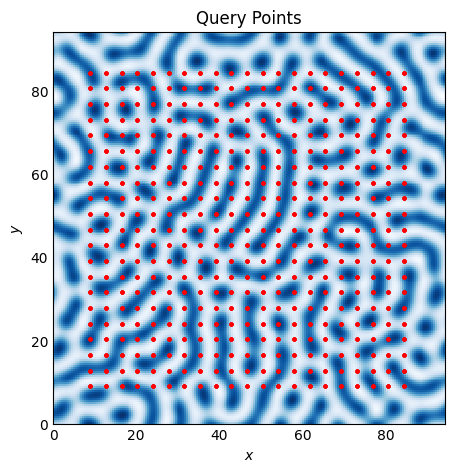


Test Functions


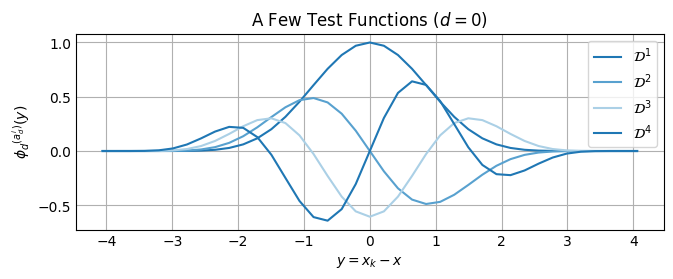


Optimal threshold = [0.002442052122205496]
Optimal loss = [0.1530897374617216]

Cond(L) = 1472.458377674421

scales = ([0.9244512819257926], 0.6732071968363694, 0.18035714285714285)
p = [11.0, 11.0, 9.0]
s = (8, 8, 4)

Discovered model:
u_t = (-0.61)(u^1) + (1.01)(u^2) + (-1.01)(u^3) + (-2.00)(u^1)_xx + (-0.99)(u^1)_xxxx + (-2.00)(u^1)_yy + (-0.99)(u^1)_yyyy + (-1.98)(u^1)_xxyy


In [32]:
# Grid parameters
(Lx, Ly, T) = (30*np.pi, 30*np.pi, 20)
(dx, dy, dt) = (Lx/U.shape[0], Ly/U.shape[1], T/U.shape[-1])

params = {
    # x = spatial domain(s)
    # dx = spatial discretization(s)
    # t = temporal domain
    # dt = temporal discretization
    # aux_fields = extra variables
    #-------------------------------
    'x' : [(0, Lx), (0, Ly)],
    'dx' : [dx, dy],
    't' : (0, T),
    'dt' : dt,

    # m = explicit (mx,...,mt) values
    # lambdas = MSTLS threshold search space
    # threshold = known optimal threshold
    # p = explicit (px,...,pt) values
    # tau = test function tolerance
    # tau_hat = Fourier test function tolerance
    # scales = explicit (yu,yx,yt) scaling factors
    # M = explicit scaling matrix
    #---------------------------------------------
    'm' : (19, 19, 28),
    #'p' : (11, 11, 9),
    #'scales' : (0.96, 0.67, 0.18),
    #'s' : (8, 8, 4),
    #'tau' : 1E-10
    #'tau_hat' : 2,

    # verbosity = create plots? (0 or 1)
    # init_guess = initial guess for (kx,kt) curve fitting
    # max_its = specify maximum number of MSTLS iterations
    # sigma_NR = noise ratio of artifical gaussian noise
    #-----------------------------------------------------
    'verbosity' : 1,
    'sigma_NR' : 0.01}

# Function library
# Monomial powers
fields = 1
powers = 4
poly = get_poly(powers, fields)
# Trig functions (NOT YET IMPLEMENTED)
trig = () # (frequency, phase) pairs
fj = {'poly': poly, 'trig': trig}

# Derivative library
lhs = ((0,0,1),) # evolution operator D^0
dimension = 2
pure_derivs = 4 # Up to fourth order
cross_derivs = 2 # Up to second order
rhs = get_alpha(dimension, pure_derivs, cross_derivs)
alpha = lhs + rhs

# Run weak SINDy
w = wsindy(U, fj, alpha, **params)